In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.layers import Dense , LSTM, Dropout
from keras.models import Sequential, load_model
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [2]:
fd_001_train = pd.read_csv("/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt",sep=" ",header=None)

In [3]:
fd_001_test = pd.read_csv("/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt",sep=" ",header=None)

In [4]:
fd_001_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  int64  
 1   1       20631 non-null  int64  
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  float64
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21      20631 non-null  int64  
 22

In [5]:
fd_001_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       13096 non-null  int64  
 1   1       13096 non-null  int64  
 2   2       13096 non-null  float64
 3   3       13096 non-null  float64
 4   4       13096 non-null  float64
 5   5       13096 non-null  float64
 6   6       13096 non-null  float64
 7   7       13096 non-null  float64
 8   8       13096 non-null  float64
 9   9       13096 non-null  float64
 10  10      13096 non-null  float64
 11  11      13096 non-null  float64
 12  12      13096 non-null  float64
 13  13      13096 non-null  float64
 14  14      13096 non-null  float64
 15  15      13096 non-null  float64
 16  16      13096 non-null  float64
 17  17      13096 non-null  float64
 18  18      13096 non-null  float64
 19  19      13096 non-null  float64
 20  20      13096 non-null  float64
 21  21      13096 non-null  int64  
 22

In [6]:
fd_001_train.shape

(20631, 28)

In [7]:
fd_001_test.shape

(13096, 28)

In [8]:
fd_001_train.drop(columns=[26,27],inplace=True)
fd_001_test.drop(columns=[26,27],inplace=True)


In [9]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

In [10]:
fd_001_train.columns = columns
fd_001_test.columns = columns

In [11]:
fd_001_train.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

In [12]:
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)
    
    return df[df['time_in_cycles'] > factor]

In [13]:
df = prepare_train_data(fd_001_train)

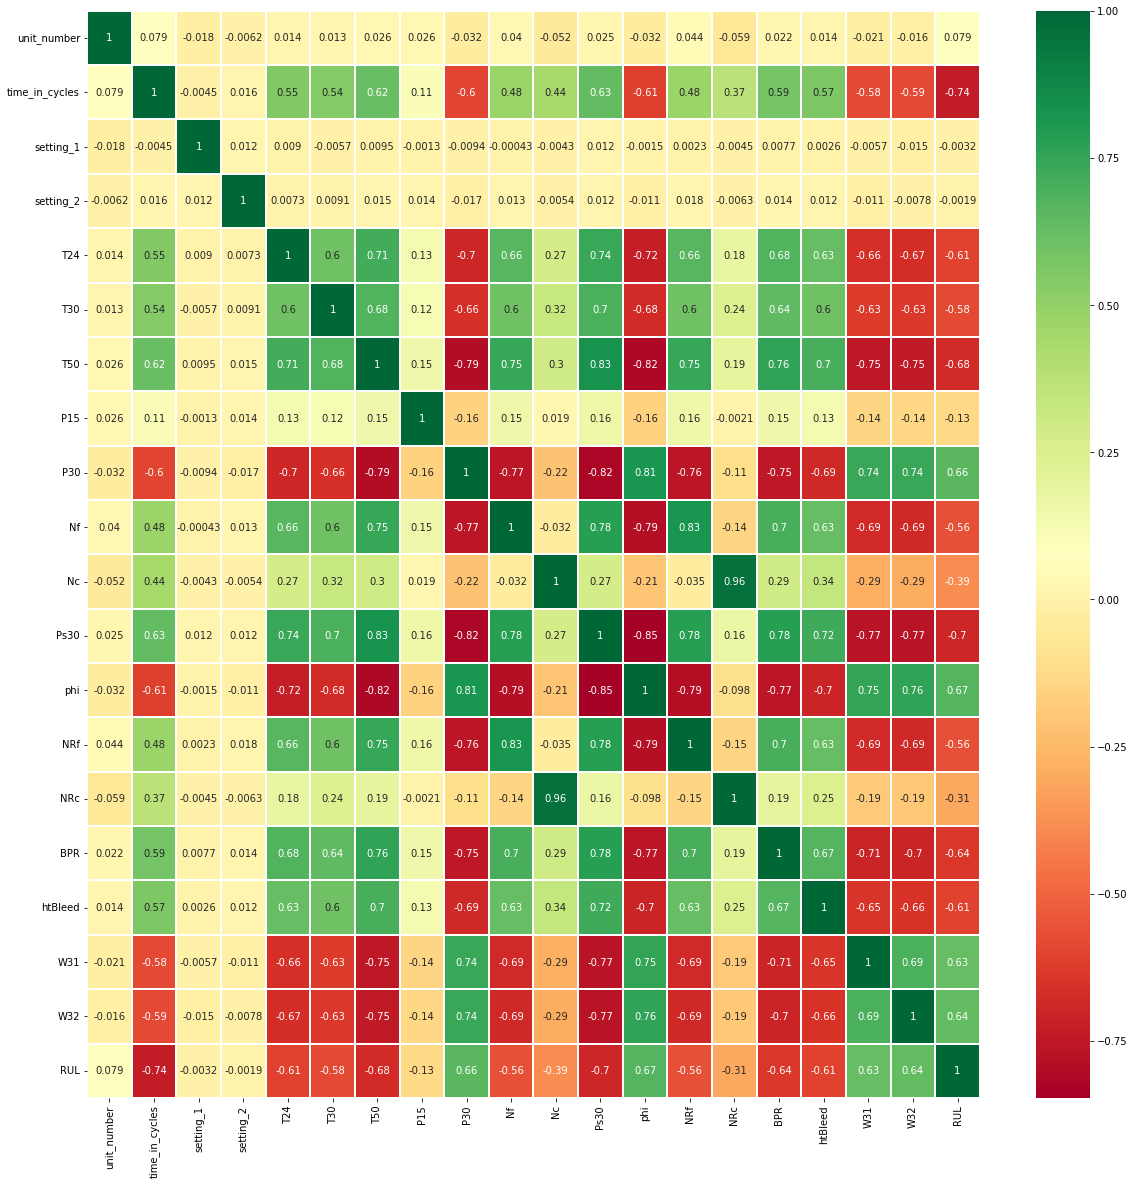

In [14]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [15]:
def score(y_true,y_pred,a1=10,a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score

In [16]:
def score_func(y_true,y_pred):
    lst = [round(score(y_true,y_pred),2), 
          round(mean_absolute_error(y_true,y_pred),2),
          round(mean_squared_error(y_true,y_pred),2)**0.5,
          round(r2_score(y_true,y_pred),2)]
    
    print(f' compatitive score {lst[0]}')
    print(f' mean absolute error {lst[1]}')
    print(f' root mean squared error {lst[2]}')
    print(f' R2 score {lst[3]}')
    return [lst[1], round(lst[2],2), lst[3]*100]

In [17]:
unit_number = pd.DataFrame(df["unit_number"])
train_df = df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'])

In [18]:
min_max_scaler=MinMaxScaler()

In [19]:
def lstm_data_preprocessing(raw_train_data, raw_test_data, raw_RUL_data):
    train_df = raw_train_data
    truth_df = raw_RUL_data
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    w1 = 30
    w0 = 15
    train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
    train_df['label2'] = train_df['label1']
    train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
    train_df['cycle_norm'] = train_df['time_in_cycles']
    cols_normalize = train_df.columns.difference(['unit_number','time_in_cycles','RUL','label1','label2'])
    norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                                 columns=cols_normalize, 
                                 index=train_df.index)

    join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
    train_df = join_df.reindex(columns = train_df.columns)
    print("train_df >> ",train_df.head())
    print("\n")
    test_df = raw_test_data.drop(columns = ['setting_1','setting_2','P15','NRc','max'])
    test_df['cycle_norm'] = test_df['time_in_cycles']
    norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                                columns=cols_normalize, 
                                index=test_df.index)
    test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
    test_df = test_join_df.reindex(columns = test_df.columns)
    test_df = test_df.reset_index(drop=True)
    rul = pd.DataFrame(test_df.groupby('unit_number')['time_in_cycles'].max()).reset_index()
    rul.columns = ['unit_number','max']
    truth_df.columns = ['more']
    truth_df['unit_number'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']
    truth_df.drop('more', axis=1, inplace=True)
    test_df = test_df.merge(truth_df, on=['unit_number'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['time_in_cycles']
    test_df.drop('max', axis=1, inplace=True) 
    test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
    test_df['label2'] = test_df['label1']
    test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
    print("test_df >> ", test_df.head())
    sequence_length = 50
    def gen_sequence(id_df, seq_length, seq_cols):
        data_matrix = id_df[seq_cols].values
        num_elements = data_matrix.shape[0]
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_matrix[start:stop, :]
    sequence_cols = list(test_df.columns[:-3])
    print(sequence_cols)
    val=list(gen_sequence(train_df[train_df['unit_number']==1], sequence_length, sequence_cols))
    print(len(val))
    seq_gen = (list(gen_sequence(train_df[train_df['unit_number']==id], sequence_length, sequence_cols)) 
               for id in train_df['unit_number'].unique())
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    print(seq_array.shape)
    def gen_labels(id_df, seq_length, label):
        data_matrix = id_df[label].values
        num_elements = data_matrix.shape[0]
        return data_matrix[seq_length:num_elements, :]
    label_gen = [gen_labels(train_df[train_df['unit_number']==id], sequence_length, ['RUL']) 
                 for id in train_df['unit_number'].unique()]
    label_array = np.concatenate(label_gen).astype(np.float32)
    print(label_array.shape)
    print(label_array)
    
    return seq_array, label_array, test_df, sequence_length, sequence_cols
    

In [20]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def lstm_train(seq_array, label_array, sequence_length):
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=50,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
    print(model.summary())
    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2)
    print(history.history.keys())
    
    return model, history

In [21]:
def lstm_test_evaluation_graphs(model, history, seq_array, label_array):
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['r2_keras'])
    plt.plot(history.history['val_r2_keras'])
    plt.title('model r^2')
    plt.ylabel('R^2')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model MAE')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
    print('\nMAE: {}'.format(scores[1]))
    print('\nR^2: {}'.format(scores[2]))
    y_pred = model.predict(seq_array,verbose=1, batch_size=200)
    y_true = label_array
    test_set = pd.DataFrame(y_pred )
    test_set.head()

In [22]:
def lstm_valid_evaluation(lstm_test_df, model, sequence_length, sequence_cols):
    seq_array_test_last = [lstm_test_df[lstm_test_df['unit_number']==id][sequence_cols].values[-sequence_length:] 
                           for id in lstm_test_df['unit_number'].unique() if len(lstm_test_df[lstm_test_df['unit_number']==id]) >= sequence_length]

    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
    y_mask = [len(lstm_test_df[lstm_test_df['unit_number']==id]) >= sequence_length for id in lstm_test_df['unit_number'].unique()]
    label_array_test_last = lstm_test_df.groupby('unit_number')['RUL'].nth(-1)[y_mask].values
    label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

    estimator = model
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last
    test_set = pd.DataFrame(y_pred_test)
    print(test_set.head())
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test)
    plt.plot(y_true_test, color="orange")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    return scores_test[1], scores_test[2]


In [23]:
def train_models(data,model = 'FOREST'):
    
    if model != 'LSTM':
        X = data.iloc[:,:14].to_numpy() 
        Y = data.iloc[:,14:].to_numpy()
        Y = np.ravel(Y)

    if model == 'FOREST':
        model = RandomForestRegressor(n_estimators=70, max_features=7, max_depth=5, n_jobs=-1, random_state=1)
        model.fit(X,Y)
        return model
    
    elif model == 'XGB':
        model = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.018, gamma=0, subsample=0.8,
                           colsample_bytree=0.5, max_depth=3,silent=True)
        model.fit(X,Y)
        return model
    elif model == 'LSTM':
        seq_array, label_array, lstm_test_df, sequence_length, sequence_cols = lstm_data_preprocessing(data[0], data[1], data[2])
        model_instance, history = lstm_train(seq_array, label_array, sequence_length)
        return model_instance, history, lstm_test_df, seq_array, label_array, sequence_length, sequence_cols
            
    return

In [24]:
def plot_result(y_true,y_pred):
    rcParams['figure.figsize'] = 12,10
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
    plt.ylabel('RUL')
    plt.xlabel('training samples')
    plt.legend(('Predicted', 'True'), loc='upper right')
    plt.title('COMPARISION OF Real and Predicted values')
    plt.show()
    return

In [25]:
fd_001_test.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)
test_max = fd_001_test.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max.columns = ['unit_number','max']
fd_001_test = fd_001_test.merge(test_max, on=['unit_number'], how='left')
test = fd_001_test[fd_001_test['time_in_cycles'] == fd_001_test['max']].reset_index()
test.drop(columns=['index','max','unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
X_001_test = test.to_numpy()

In [26]:
X_001_test.shape

(100, 14)

In [27]:
fd_001_test.head()

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,max
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,31
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,31
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,31
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,31
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,31


In [28]:
model_1 = train_models(train_df)
y_pred = model_1.predict(X_001_test)
RUL = pd.read_csv("/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt",sep=" ",header=None)
y_true = RUL[0].to_numpy()
RUL.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [29]:
RF_individual_scorelst = score_func(y_true, y_pred)

 compatitive score 1057.2
 mean absolute error 19.25
 root mean squared error 24.45219826518671
 R2 score 0.65


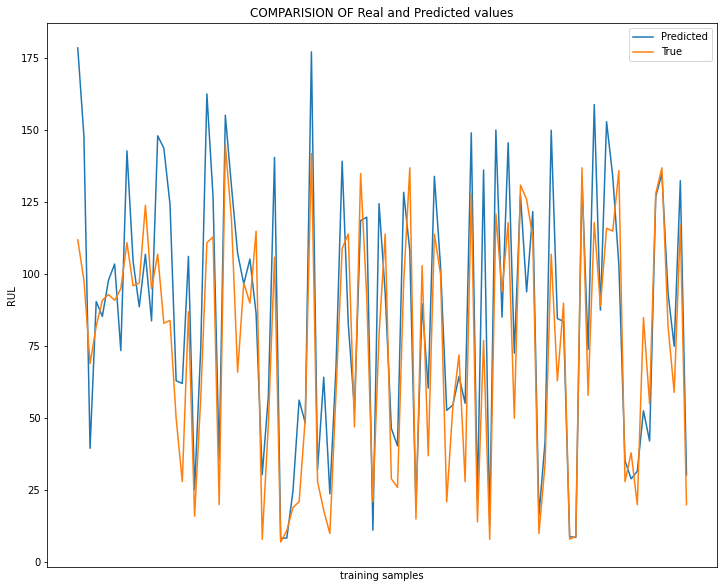

In [30]:
plot_result(y_true,y_pred)

In [31]:
train_df_lstm = pd.concat([unit_number, train_df], axis=1)
model, history, lstm_test_df, seq_array, label_array, sequence_length, sequence_cols = train_models([train_df_lstm, fd_001_test, RUL.copy()], "LSTM")

train_df >>     unit_number  time_in_cycles       T24       T30       T50       P30  \
0            1               1  0.183735  0.406802  0.309757  0.726248   
1            1               2  0.283133  0.453019  0.352633  0.628019   
2            1               3  0.343373  0.369523  0.370527  0.710145   
3            1               4  0.343373  0.256159  0.331195  0.740741   
4            1               5  0.349398  0.257467  0.404625  0.668277   

         Nf        Nc      Ps30       phi       NRf       BPR   htBleed  \
0  0.242424  0.109755  0.369048  0.633262  0.205882  0.363986  0.333333   
1  0.212121  0.100242  0.380952  0.765458  0.279412  0.411312  0.333333   
2  0.272727  0.140043  0.250000  0.795309  0.220588  0.357445  0.166667   
3  0.318182  0.124518  0.166667  0.889126  0.294118  0.166603  0.333333   
4  0.242424  0.149960  0.255952  0.746269  0.235294  0.402078  0.416667   

        W31       W32  RUL  label1  label2  cycle_norm  
0  0.713178  0.724662  191       0

2022-03-20 04:52:12.332407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 04:52:12.442347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 04:52:12.443066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 04:52:12.444518: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           46800     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 77,051
Trainable params: 77,051
Non-trainable params: 0
____________________________________________________

2022-03-20 04:52:15.392956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-20 04:52:18.794435: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


75/75 - 6s - loss: 8808.1992 - mae: 75.1608 - r2_keras: -1.7247e+00 - val_loss: 8188.5469 - val_mae: 72.0495 - val_r2_keras: -2.4418e+00
Epoch 2/60
75/75 - 1s - loss: 8096.0166 - mae: 71.0094 - r2_keras: -1.4951e+00 - val_loss: 7662.0933 - val_mae: 68.9910 - val_r2_keras: -2.1933e+00
Epoch 3/60
75/75 - 1s - loss: 7581.6982 - mae: 68.0644 - r2_keras: -1.3347e+00 - val_loss: 7169.7290 - val_mae: 66.1492 - val_r2_keras: -1.9628e+00
Epoch 4/60
75/75 - 1s - loss: 7102.8936 - mae: 65.3300 - r2_keras: -1.1871e+00 - val_loss: 6706.7109 - val_mae: 63.4939 - val_r2_keras: -1.7479e+00
Epoch 5/60
75/75 - 1s - loss: 6656.3247 - mae: 62.7801 - r2_keras: -1.0476e+00 - val_loss: 6266.0142 - val_mae: 60.8956 - val_r2_keras: -1.5455e+00
Epoch 6/60
75/75 - 1s - loss: 6230.7563 - mae: 60.3278 - r2_keras: -9.2360e-01 - val_loss: 5862.7832 - val_mae: 58.7079 - val_r2_keras: -1.3627e+00
Epoch 7/60
75/75 - 1s - loss: 5834.3154 - mae: 58.1196 - r2_keras: -7.9483e-01 - val_loss: 5481.9009 - val_mae: 56.4882 - v

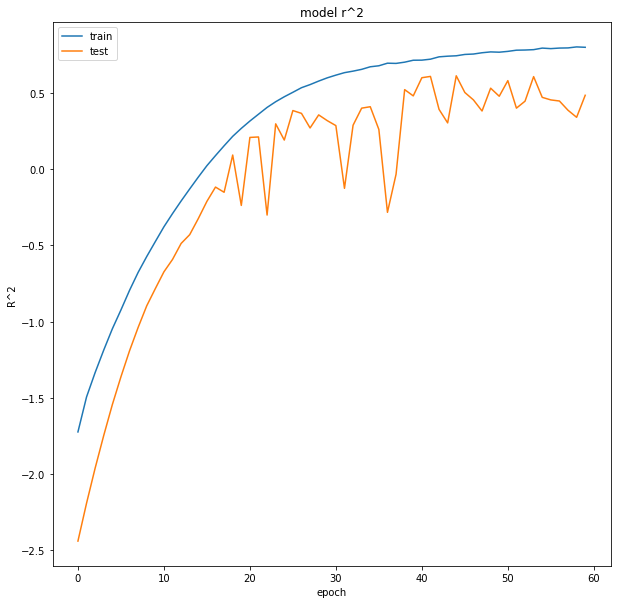

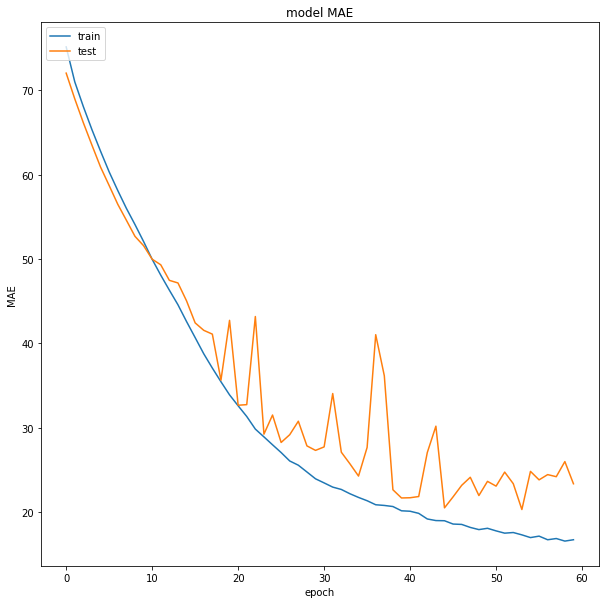

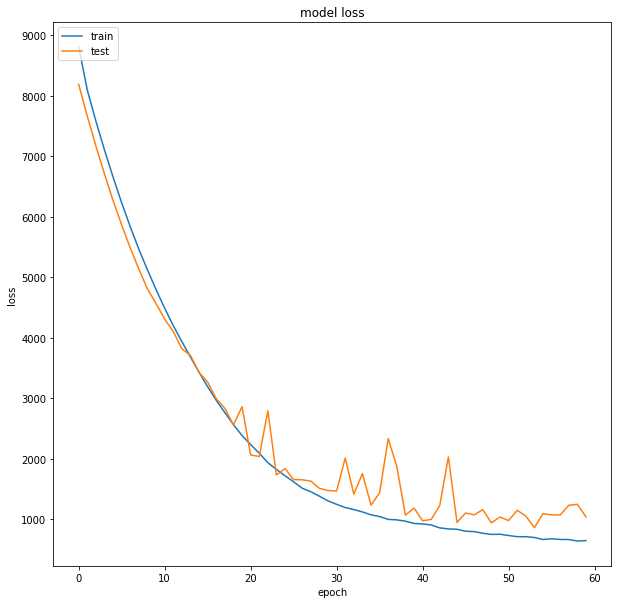

79/79 [==============================] - 0s 5ms/step - loss: 524.6943 - mae: 14.0913 - r2_keras: 0.8179

MAE: 14.091341972351074

R^2: 0.8179184198379517
79/79 [==============================] - 1s 3ms/step


In [32]:
lstm_test_evaluation_graphs(model, history, seq_array, label_array)

3/3 - 0s - loss: 533.9389 - mae: 15.9635 - r2_keras: 0.6749

MAE: 15.963510513305664

R^2: 0.6748878359794617
           0
0  53.722603
1  80.727829
2  85.593147
3  78.271278
4  91.379089


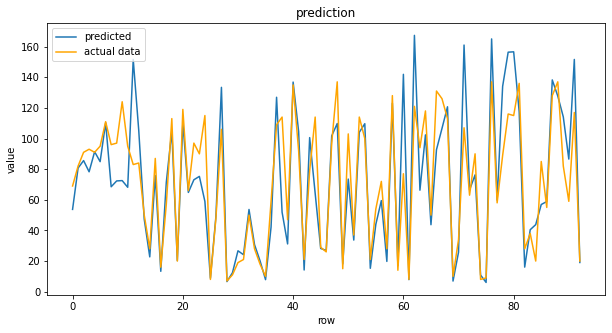

In [33]:
MAE, R2 = lstm_valid_evaluation(lstm_test_df, model, sequence_length, sequence_cols)
LSTM_individual_scorelst = [round(MAE,2), 0, round(R2,2)*100]


In [34]:
def single_train(test_data,train_data,algorithm):
    y_single_pred = []
    for sample in tqdm(test_data):
        time.sleep(0.01)
        single_train_df = prepare_train_data(train_data, factor = sample[0])
        single_train_df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
        model = train_models(single_train_df,algorithm)
        y_p = model.predict(sample.reshape(1,-1))[0]
        y_single_pred.append(y_p)
    y_single_pred = np.array(y_single_pred)
    return y_single_pred

In [35]:
y_single_pred = single_train(X_001_test,fd_001_train,'FOREST')

100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


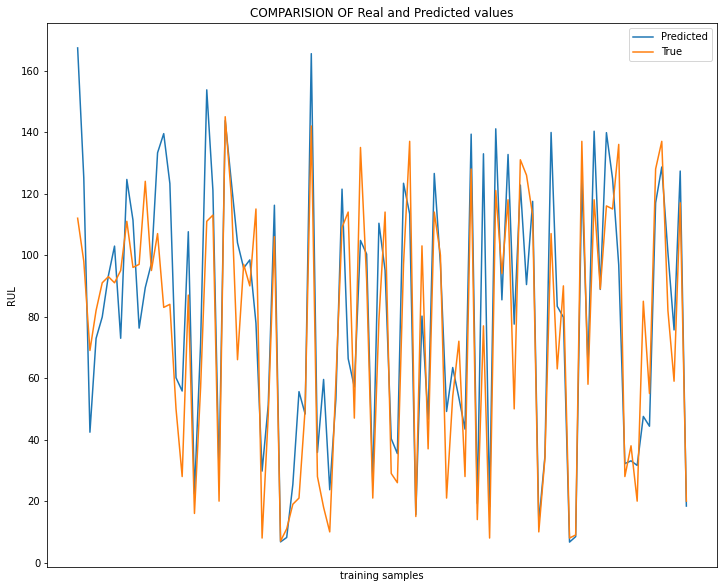

In [36]:
plot_result(y_true,y_single_pred)

In [37]:
RF_SingleTrain_scorelst = score_func(y_true, y_single_pred)

 compatitive score 868.02
 mean absolute error 16.49
 root mean squared error 21.342445970413046
 R2 score 0.74


In [38]:
y_single_pred

array([167.37738495, 125.13993734,  42.41466659,  72.92753245,
        79.87791841,  93.29801657, 102.93265852,  72.95938508,
       124.60567806, 111.38365257,  76.2579769 ,  89.4483941 ,
        97.34373918, 133.28173439, 139.50221353, 123.28010717,
        60.12311808,  55.80735125, 107.60687961,  22.34818485,
        71.32475976, 153.74152108, 121.07390416,  28.86036457,
       143.73201796, 123.73423456, 104.00937057,  95.79852076,
        98.449328  ,  77.89380916,  29.76435409,  51.25217339,
       116.21832766,   6.75076402,   8.18805343,  25.41959302,
        55.60528828,  48.34778967, 165.50546133,  35.84158019,
        59.56804209,  23.70265897,  53.14789047, 121.45343608,
        66.33165377,  57.11892477, 104.77110735, 100.32278063,
        25.43812838, 110.36022024,  95.10919923,  40.31551675,
        35.46521009, 123.35931064, 113.39902049,  15.65297446,
        80.16790937,  46.62879288, 126.54720928,  97.06474485,
        49.16111713,  63.44734772,  53.63951209,  43.40

In [39]:
def prepare_test_data(fd_001_test,n=0):
    test = fd_001_test[fd_001_test['time_in_cycles'] == fd_001_test['max'] - n].reset_index()
    test.drop(columns=['index','max','unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
    X_return = test.to_numpy()
    return X_return

In [40]:
N=5
y_n_pred = y_single_pred
for i in range(1,N):
    X_001_test = prepare_test_data(fd_001_test,i)
    y_single_i_pred = single_train(X_001_test,fd_001_train,'FOREST')    
    y_n_pred = np.vstack((y_n_pred,y_single_i_pred))  

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


In [41]:
y_multi_pred = np.mean(y_n_pred,axis = 0)
RF_5avg_scorelst = score_func(y_true,y_multi_pred)

 compatitive score 810.53
 mean absolute error 17.78
 root mean squared error 22.172505496673125
 R2 score 0.72


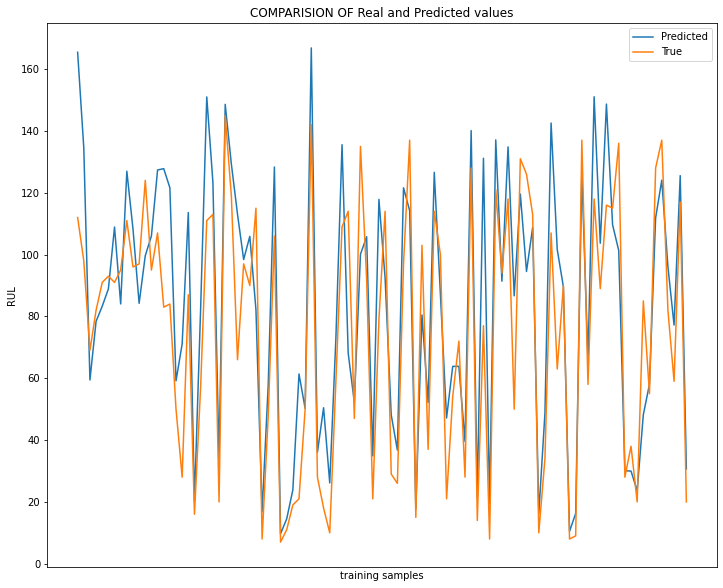

In [42]:
plot_result(y_true,y_multi_pred)

In [43]:
N=10
for i in range(5,N):
    X_001_test = prepare_test_data(fd_001_test,i)
    y_single_i_pred = single_train(X_001_test,fd_001_train,'FOREST')    
    y_n_pred = np.vstack((y_n_pred,y_single_i_pred))  

100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


In [44]:
y_multi_pred_10 = np.mean(y_n_pred,axis = 0)
score_func(y_true,y_multi_pred_10)

 compatitive score 880.85
 mean absolute error 19.39
 root mean squared error 23.41922287352849
 R2 score 0.68


[19.39, 23.42, 68.0]

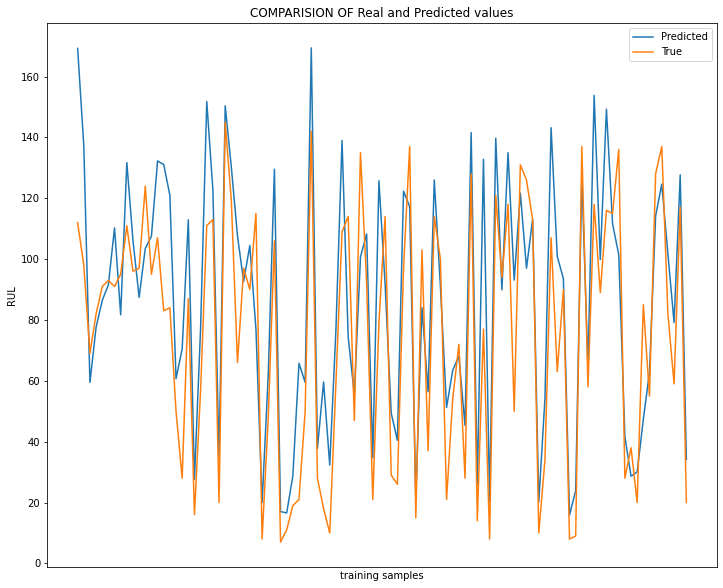

In [45]:
plot_result(y_true,y_multi_pred_10)

In [46]:
xgb = train_models(train_df,model="XGB")
y_xgb_pred = xgb.predict(X_001_test)
XGB_individual_scorelst = score_func(y_true,y_xgb_pred)

[05:07:05] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 compatitive score 1113.25
 mean absolute error 20.36
 root mean squared error 24.346457647879703
 R2 score 0.66


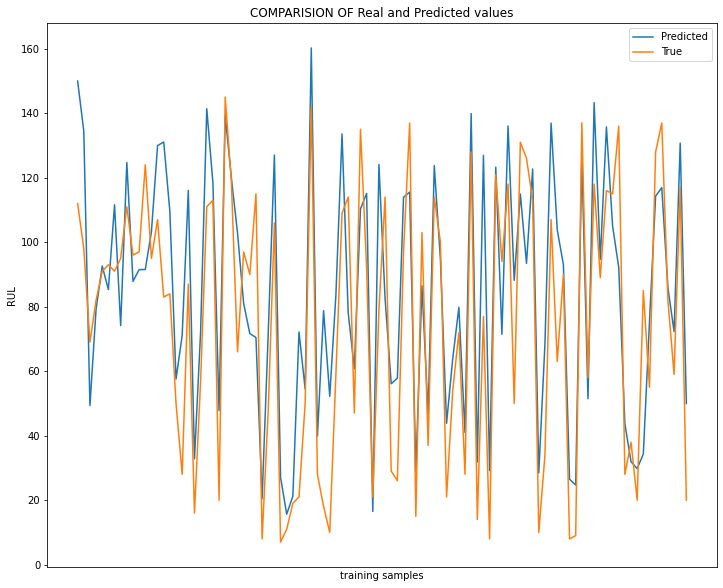

In [47]:
plot_result(y_true,y_xgb_pred)

In [48]:
y_single_xgb_pred = single_train(X_001_test,fd_001_train,'XGB')

  0%|          | 0/100 [00:00<?, ?it/s]

[05:07:07] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  1%|          | 1/100 [00:00<01:11,  1.38it/s]

[05:07:08] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  2%|▏         | 2/100 [00:01<01:06,  1.47it/s]

[05:07:09] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  3%|▎         | 3/100 [00:01<00:54,  1.79it/s]

[05:07:09] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  4%|▍         | 4/100 [00:02<00:50,  1.89it/s]

[05:07:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  5%|▌         | 5/100 [00:02<00:49,  1.92it/s]

[05:07:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  6%|▌         | 6/100 [00:03<00:47,  1.96it/s]

[05:07:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  7%|▋         | 7/100 [00:03<00:40,  2.28it/s]

[05:07:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  8%|▊         | 8/100 [00:03<00:35,  2.58it/s]

[05:07:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 10%|█         | 10/100 [00:05<00:42,  2.10it/s]

[05:07:12] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 12%|█▏        | 12/100 [00:05<00:34,  2.56it/s]

[05:07:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 13%|█▎        | 13/100 [00:05<00:28,  3.03it/s]

[05:07:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 14%|█▍        | 14/100 [00:06<00:37,  2.30it/s]

[05:07:14] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 15%|█▌        | 15/100 [00:07<00:40,  2.10it/s]

[05:07:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 16%|█▌        | 16/100 [00:07<00:39,  2.14it/s]

[05:07:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 17%|█▋        | 17/100 [00:07<00:34,  2.43it/s]

[05:07:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 18%|█▊        | 18/100 [00:08<00:33,  2.47it/s]

[05:07:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 20%|██        | 20/100 [00:08<00:27,  2.89it/s]

[05:07:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 21%|██        | 21/100 [00:09<00:27,  2.83it/s]

[05:07:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 22%|██▏       | 22/100 [00:10<00:35,  2.20it/s]

[05:07:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 24%|██▍       | 24/100 [00:10<00:28,  2.70it/s]

[05:07:18] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:18] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 25%|██▌       | 25/100 [00:11<00:34,  2.15it/s]

[05:07:19] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 26%|██▌       | 26/100 [00:11<00:37,  2.00it/s]

[05:07:19] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 27%|██▋       | 27/100 [00:12<00:33,  2.17it/s]

[05:07:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 28%|██▊       | 28/100 [00:12<00:29,  2.42it/s]

[05:07:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 29%|██▉       | 29/100 [00:12<00:26,  2.70it/s]

[05:07:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 31%|███       | 31/100 [00:13<00:21,  3.20it/s]

[05:07:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 32%|███▏      | 32/100 [00:13<00:21,  3.10it/s]

[05:07:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 34%|███▍      | 34/100 [00:14<00:22,  2.88it/s]

[05:07:22] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:22] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 35%|███▌      | 35/100 [00:14<00:19,  3.35it/s]

[05:07:22] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 36%|███▌      | 36/100 [00:16<00:43,  1.47it/s]

[05:07:24] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 37%|███▋      | 37/100 [00:16<00:38,  1.63it/s]

[05:07:24] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 38%|███▊      | 38/100 [00:17<00:34,  1.80it/s]

[05:07:25] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 39%|███▉      | 39/100 [00:17<00:36,  1.68it/s]

[05:07:25] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 40%|████      | 40/100 [00:18<00:32,  1.83it/s]

[05:07:26] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 41%|████      | 41/100 [00:18<00:30,  1.94it/s]

[05:07:26] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 42%|████▏     | 42/100 [00:19<00:26,  2.21it/s]

[05:07:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 43%|████▎     | 43/100 [00:19<00:22,  2.51it/s]

[05:07:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 44%|████▍     | 44/100 [00:19<00:26,  2.11it/s]

[05:07:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 45%|████▌     | 45/100 [00:20<00:24,  2.28it/s]

[05:07:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 46%|████▌     | 46/100 [00:20<00:22,  2.41it/s]

[05:07:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 47%|████▋     | 47/100 [00:21<00:25,  2.12it/s]

[05:07:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 48%|████▊     | 48/100 [00:21<00:26,  1.98it/s]

[05:07:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 50%|█████     | 50/100 [00:22<00:21,  2.38it/s]

[05:07:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 52%|█████▏    | 52/100 [00:23<00:16,  2.84it/s]

[05:07:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 53%|█████▎    | 53/100 [00:23<00:15,  3.00it/s]

[05:07:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 54%|█████▍    | 54/100 [00:23<00:16,  2.78it/s]

[05:07:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 55%|█████▌    | 55/100 [00:24<00:17,  2.57it/s]

[05:07:32] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 56%|█████▌    | 56/100 [00:24<00:17,  2.57it/s]

[05:07:32] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 57%|█████▋    | 57/100 [00:24<00:15,  2.76it/s]

[05:07:32] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 58%|█████▊    | 58/100 [00:25<00:13,  3.01it/s]

[05:07:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 59%|█████▉    | 59/100 [00:25<00:16,  2.56it/s]

[05:07:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 60%|██████    | 60/100 [00:26<00:15,  2.65it/s]

[05:07:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 62%|██████▏   | 62/100 [00:27<00:15,  2.47it/s]

[05:07:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 63%|██████▎   | 63/100 [00:27<00:14,  2.52it/s]

[05:07:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 64%|██████▍   | 64/100 [00:27<00:13,  2.70it/s]

[05:07:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 65%|██████▌   | 65/100 [00:28<00:16,  2.16it/s]

[05:07:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 66%|██████▌   | 66/100 [00:28<00:15,  2.24it/s]

[05:07:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 68%|██████▊   | 68/100 [00:29<00:13,  2.34it/s]

[05:07:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 69%|██████▉   | 69/100 [00:30<00:15,  1.99it/s]

[05:07:38] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 70%|███████   | 70/100 [00:31<00:18,  1.58it/s]

[05:07:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 71%|███████   | 71/100 [00:31<00:18,  1.60it/s]

[05:07:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 72%|███████▏  | 72/100 [00:32<00:15,  1.79it/s]

[05:07:40] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 73%|███████▎  | 73/100 [00:32<00:14,  1.89it/s]

[05:07:40] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 74%|███████▍  | 74/100 [00:33<00:12,  2.06it/s]

[05:07:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 76%|███████▌  | 76/100 [00:33<00:09,  2.49it/s]

[05:07:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 77%|███████▋  | 77/100 [00:34<00:08,  2.72it/s]

[05:07:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 78%|███████▊  | 78/100 [00:34<00:09,  2.29it/s]

[05:07:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 79%|███████▉  | 79/100 [00:35<00:09,  2.20it/s]

[05:07:43] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 81%|████████  | 81/100 [00:35<00:06,  2.85it/s]

[05:07:43] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:43] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 82%|████████▏ | 82/100 [00:36<00:06,  2.98it/s]

[05:07:44] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 83%|████████▎ | 83/100 [00:36<00:06,  2.44it/s]

[05:07:44] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 84%|████████▍ | 84/100 [00:37<00:05,  2.75it/s]

[05:07:44] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 85%|████████▌ | 85/100 [00:38<00:08,  1.67it/s]

[05:07:46] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 86%|████████▌ | 86/100 [00:38<00:07,  1.78it/s]

[05:07:46] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 87%|████████▋ | 87/100 [00:39<00:07,  1.66it/s]

[05:07:47] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 88%|████████▊ | 88/100 [00:39<00:07,  1.65it/s]

[05:07:47] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 89%|████████▉ | 89/100 [00:40<00:05,  2.01it/s]

[05:07:48] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 91%|█████████ | 91/100 [00:40<00:03,  2.85it/s]

[05:07:48] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:48] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 93%|█████████▎| 93/100 [00:41<00:01,  3.66it/s]

[05:07:48] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:07:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 94%|█████████▍| 94/100 [00:41<00:01,  3.23it/s]

[05:07:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 95%|█████████▌| 95/100 [00:42<00:01,  2.61it/s]

[05:07:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 96%|█████████▌| 96/100 [00:42<00:01,  2.37it/s]

[05:07:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 97%|█████████▋| 97/100 [00:42<00:01,  2.40it/s]

[05:07:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 98%|█████████▊| 98/100 [00:43<00:00,  2.36it/s]

[05:07:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




100%|██████████| 100/100 [00:44<00:00,  2.27it/s]

[05:07:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [49]:
XGB_SingleTrain_scorelst = score_func(y_true,y_single_xgb_pred)

 compatitive score 1238.36
 mean absolute error 19.16
 root mean squared error 22.958658497394833
 R2 score 0.69


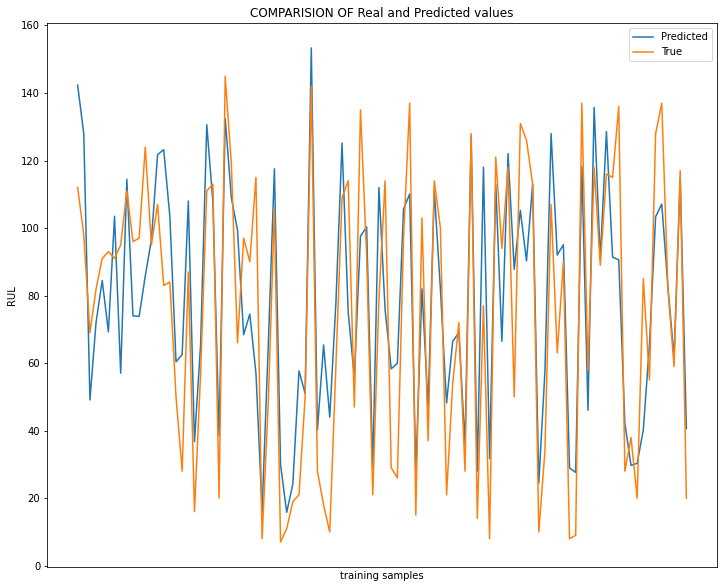

In [50]:
plot_result(y_true,y_single_xgb_pred)

In [51]:
N=5
y_n_pred = y_single_xgb_pred
for i in range(1,N):
    X_001_test = prepare_test_data(fd_001_test,i)
    y_single_i_pred = single_train(X_001_test,fd_001_train,'XGB')    
    y_n_pred = np.vstack((y_n_pred,y_single_i_pred)) 

  0%|          | 0/100 [00:00<?, ?it/s]

[05:07:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  1%|          | 1/100 [00:01<03:09,  1.92s/it]

[05:07:57] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  2%|▏         | 2/100 [00:02<01:55,  1.17s/it]

[05:07:58] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  3%|▎         | 3/100 [00:02<01:19,  1.23it/s]

[05:07:58] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  4%|▍         | 4/100 [00:03<01:04,  1.48it/s]

[05:07:58] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  5%|▌         | 5/100 [00:03<00:57,  1.66it/s]

[05:07:59] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  6%|▌         | 6/100 [00:04<00:52,  1.81it/s]

[05:07:59] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  7%|▋         | 7/100 [00:04<00:42,  2.17it/s]

[05:08:00] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  8%|▊         | 8/100 [00:04<00:36,  2.54it/s]

[05:08:00] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 10%|█         | 10/100 [00:05<00:33,  2.65it/s]

[05:08:00] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 12%|█▏        | 12/100 [00:06<00:29,  3.01it/s]

[05:08:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 13%|█▎        | 13/100 [00:06<00:24,  3.53it/s]

[05:08:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 14%|█▍        | 14/100 [00:07<00:34,  2.53it/s]

[05:08:02] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 15%|█▌        | 15/100 [00:07<00:37,  2.26it/s]

[05:08:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 16%|█▌        | 16/100 [00:08<00:36,  2.27it/s]

[05:08:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 17%|█▋        | 17/100 [00:08<00:31,  2.61it/s]

[05:08:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 18%|█▊        | 18/100 [00:08<00:30,  2.66it/s]

[05:08:04] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 20%|██        | 20/100 [00:09<00:25,  3.15it/s]

[05:08:04] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:04] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 21%|██        | 21/100 [00:09<00:24,  3.17it/s]

[05:08:05] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 22%|██▏       | 22/100 [00:10<00:33,  2.36it/s]

[05:08:05] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 24%|██▍       | 24/100 [00:10<00:26,  2.90it/s]

[05:08:06] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:06] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 25%|██▌       | 25/100 [00:11<00:32,  2.30it/s]

[05:08:06] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 26%|██▌       | 26/100 [00:12<00:44,  1.66it/s]

[05:08:07] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 27%|██▋       | 27/100 [00:12<00:38,  1.91it/s]

[05:08:08] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 28%|██▊       | 28/100 [00:13<00:32,  2.23it/s]

[05:08:08] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 29%|██▉       | 29/100 [00:13<00:27,  2.60it/s]

[05:08:08] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 31%|███       | 31/100 [00:13<00:21,  3.26it/s]

[05:08:09] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:09] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 32%|███▏      | 32/100 [00:14<00:21,  3.22it/s]

[05:08:09] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 34%|███▍      | 34/100 [00:14<00:22,  2.98it/s]

[05:08:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 35%|███▌      | 35/100 [00:15<00:18,  3.52it/s]

[05:08:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 36%|███▌      | 36/100 [00:15<00:20,  3.18it/s]

[05:08:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 37%|███▋      | 37/100 [00:15<00:21,  2.92it/s]

[05:08:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 38%|███▊      | 38/100 [00:16<00:22,  2.80it/s]

[05:08:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 39%|███▉      | 39/100 [00:16<00:27,  2.21it/s]

[05:08:12] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 40%|████      | 40/100 [00:17<00:25,  2.35it/s]

[05:08:12] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 41%|████      | 41/100 [00:17<00:24,  2.40it/s]

[05:08:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 42%|████▏     | 42/100 [00:18<00:21,  2.66it/s]

[05:08:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 43%|████▎     | 43/100 [00:18<00:19,  2.99it/s]

[05:08:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 44%|████▍     | 44/100 [00:18<00:23,  2.35it/s]

[05:08:14] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 45%|████▌     | 45/100 [00:19<00:21,  2.59it/s]

[05:08:14] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 46%|████▌     | 46/100 [00:19<00:19,  2.74it/s]

[05:08:14] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 47%|████▋     | 47/100 [00:20<00:22,  2.34it/s]

[05:08:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 48%|████▊     | 48/100 [00:20<00:24,  2.15it/s]

[05:08:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 50%|█████     | 50/100 [00:21<00:19,  2.54it/s]

[05:08:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 52%|█████▏    | 52/100 [00:21<00:15,  3.05it/s]

[05:08:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 53%|█████▎    | 53/100 [00:22<00:14,  3.24it/s]

[05:08:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 54%|█████▍    | 54/100 [00:22<00:15,  2.98it/s]

[05:08:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 55%|█████▌    | 55/100 [00:23<00:21,  2.05it/s]

[05:08:18] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 56%|█████▌    | 56/100 [00:23<00:19,  2.23it/s]

[05:08:19] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 58%|█████▊    | 58/100 [00:24<00:14,  2.85it/s]

[05:08:19] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:19] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 59%|█████▉    | 59/100 [00:24<00:16,  2.52it/s]

[05:08:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 60%|██████    | 60/100 [00:25<00:14,  2.68it/s]

[05:08:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 62%|██████▏   | 62/100 [00:25<00:10,  3.66it/s]

[05:08:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 63%|██████▎   | 63/100 [00:25<00:10,  3.62it/s]

[05:08:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 64%|██████▍   | 64/100 [00:25<00:09,  3.73it/s]

[05:08:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 65%|██████▌   | 65/100 [00:26<00:12,  2.80it/s]

[05:08:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 66%|██████▌   | 66/100 [00:26<00:11,  2.90it/s]

[05:08:22] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 68%|██████▊   | 68/100 [00:27<00:11,  2.91it/s]

[05:08:22] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:23] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 69%|██████▉   | 69/100 [00:28<00:13,  2.33it/s]

[05:08:23] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 70%|███████   | 70/100 [00:28<00:11,  2.57it/s]

[05:08:23] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 71%|███████   | 71/100 [00:29<00:12,  2.26it/s]

[05:08:24] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 72%|███████▏  | 72/100 [00:29<00:11,  2.35it/s]

[05:08:24] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 73%|███████▎  | 73/100 [00:29<00:11,  2.34it/s]

[05:08:25] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 74%|███████▍  | 74/100 [00:30<00:13,  1.92it/s]

[05:08:26] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 76%|███████▌  | 76/100 [00:31<00:11,  2.14it/s]

[05:08:26] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 77%|███████▋  | 77/100 [00:31<00:09,  2.43it/s]

[05:08:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 78%|███████▊  | 78/100 [00:32<00:10,  2.19it/s]

[05:08:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 79%|███████▉  | 79/100 [00:32<00:10,  2.09it/s]

[05:08:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 81%|████████  | 81/100 [00:33<00:07,  2.67it/s]

[05:08:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 82%|████████▏ | 82/100 [00:34<00:11,  1.54it/s]

[05:08:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 83%|████████▎ | 83/100 [00:35<00:10,  1.60it/s]

[05:08:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 84%|████████▍ | 84/100 [00:35<00:08,  1.97it/s]

[05:08:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 85%|████████▌ | 85/100 [00:36<00:08,  1.78it/s]

[05:08:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 86%|████████▌ | 86/100 [00:36<00:07,  1.91it/s]

[05:08:32] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 87%|████████▋ | 87/100 [00:37<00:07,  1.78it/s]

[05:08:32] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 89%|████████▉ | 89/100 [00:38<00:05,  2.18it/s]

[05:08:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 91%|█████████ | 91/100 [00:38<00:02,  3.11it/s]

[05:08:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 92%|█████████▏| 92/100 [00:38<00:02,  3.17it/s]

[05:08:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 94%|█████████▍| 94/100 [00:39<00:01,  3.66it/s]

[05:08:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 95%|█████████▌| 95/100 [00:39<00:01,  3.00it/s]

[05:08:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 96%|█████████▌| 96/100 [00:40<00:01,  2.68it/s]

[05:08:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 97%|█████████▋| 97/100 [00:40<00:01,  2.71it/s]

[05:08:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 98%|█████████▊| 98/100 [00:41<00:00,  2.63it/s]

[05:08:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


[05:08:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  0%|          | 0/100 [00:00<?, ?it/s]

[05:08:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  1%|          | 1/100 [00:00<01:08,  1.44it/s]

[05:08:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  2%|▏         | 2/100 [00:01<01:05,  1.51it/s]

[05:08:38] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  3%|▎         | 3/100 [00:01<00:52,  1.85it/s]

[05:08:38] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  4%|▍         | 4/100 [00:02<00:49,  1.96it/s]

[05:08:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  5%|▌         | 5/100 [00:02<00:47,  1.99it/s]

[05:08:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  6%|▌         | 6/100 [00:03<00:59,  1.58it/s]

[05:08:40] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  7%|▋         | 7/100 [00:03<00:48,  1.92it/s]

[05:08:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  8%|▊         | 8/100 [00:04<00:40,  2.29it/s]

[05:08:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 10%|█         | 10/100 [00:04<00:36,  2.48it/s]

[05:08:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 12%|█▏        | 12/100 [00:05<00:30,  2.87it/s]

[05:08:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 13%|█▎        | 13/100 [00:05<00:25,  3.39it/s]

[05:08:43] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 14%|█▍        | 14/100 [00:06<00:34,  2.48it/s]

[05:08:43] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 15%|█▌        | 15/100 [00:06<00:38,  2.22it/s]

[05:08:44] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 16%|█▌        | 16/100 [00:07<00:38,  2.21it/s]

[05:08:44] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 17%|█▋        | 17/100 [00:07<00:33,  2.51it/s]

[05:08:44] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 18%|█▊        | 18/100 [00:08<00:32,  2.53it/s]

[05:08:45] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 20%|██        | 20/100 [00:08<00:26,  3.01it/s]

[05:08:45] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:45] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 21%|██        | 21/100 [00:09<00:25,  3.05it/s]

[05:08:46] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 22%|██▏       | 22/100 [00:09<00:33,  2.31it/s]

[05:08:46] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 24%|██▍       | 24/100 [00:10<00:27,  2.80it/s]

[05:08:47] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:47] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 25%|██▌       | 25/100 [00:10<00:33,  2.26it/s]

[05:08:48] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 26%|██▌       | 26/100 [00:11<00:35,  2.06it/s]

[05:08:48] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 27%|██▋       | 27/100 [00:11<00:32,  2.26it/s]

[05:08:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 28%|██▊       | 28/100 [00:12<00:28,  2.55it/s]

[05:08:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 29%|██▉       | 29/100 [00:12<00:24,  2.87it/s]

[05:08:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 31%|███       | 31/100 [00:12<00:20,  3.38it/s]

[05:08:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 32%|███▏      | 32/100 [00:13<00:20,  3.26it/s]

[05:08:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 33%|███▎      | 33/100 [00:13<00:28,  2.36it/s]

[05:08:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 35%|███▌      | 35/100 [00:14<00:23,  2.76it/s]

[05:08:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 36%|███▌      | 36/100 [00:14<00:23,  2.68it/s]

[05:08:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 37%|███▋      | 37/100 [00:15<00:24,  2.59it/s]

[05:08:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 38%|███▊      | 38/100 [00:15<00:24,  2.57it/s]

[05:08:53] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 39%|███▉      | 39/100 [00:16<00:29,  2.09it/s]

[05:08:53] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 40%|████      | 40/100 [00:16<00:26,  2.25it/s]

[05:08:54] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 41%|████      | 41/100 [00:17<00:25,  2.32it/s]

[05:08:54] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 42%|████▏     | 42/100 [00:17<00:22,  2.58it/s]

[05:08:54] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 43%|████▎     | 43/100 [00:17<00:19,  2.92it/s]

[05:08:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 44%|████▍     | 44/100 [00:18<00:23,  2.33it/s]

[05:08:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 45%|████▌     | 45/100 [00:18<00:21,  2.57it/s]

[05:08:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 46%|████▌     | 46/100 [00:19<00:19,  2.71it/s]

[05:08:56] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 47%|████▋     | 47/100 [00:19<00:22,  2.33it/s]

[05:08:56] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 48%|████▊     | 48/100 [00:20<00:35,  1.46it/s]

[05:08:58] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:58] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 50%|█████     | 50/100 [00:21<00:25,  1.93it/s]

[05:08:58] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 52%|█████▏    | 52/100 [00:22<00:19,  2.49it/s]

[05:08:59] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:59] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 53%|█████▎    | 53/100 [00:22<00:17,  2.74it/s]

[05:08:59] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 54%|█████▍    | 54/100 [00:22<00:17,  2.66it/s]

[05:08:59] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 55%|█████▌    | 55/100 [00:23<00:17,  2.54it/s]

[05:09:00] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 56%|█████▌    | 56/100 [00:23<00:16,  2.60it/s]

[05:09:00] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 58%|█████▊    | 58/100 [00:24<00:13,  3.17it/s]

[05:09:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 59%|█████▉    | 59/100 [00:24<00:15,  2.71it/s]

[05:09:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 60%|██████    | 60/100 [00:25<00:26,  1.50it/s]

[05:09:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 62%|██████▏   | 62/100 [00:26<00:16,  2.31it/s]

[05:09:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 63%|██████▎   | 63/100 [00:26<00:14,  2.56it/s]

[05:09:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 64%|██████▍   | 64/100 [00:26<00:12,  2.87it/s]

[05:09:04] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 65%|██████▌   | 65/100 [00:27<00:14,  2.41it/s]

[05:09:04] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 66%|██████▌   | 66/100 [00:27<00:13,  2.59it/s]

[05:09:05] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 68%|██████▊   | 68/100 [00:28<00:11,  2.73it/s]

[05:09:05] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:05] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 69%|██████▉   | 69/100 [00:29<00:13,  2.24it/s]

[05:09:06] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 70%|███████   | 70/100 [00:29<00:12,  2.48it/s]

[05:09:06] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 71%|███████   | 71/100 [00:30<00:13,  2.17it/s]

[05:09:07] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 72%|███████▏  | 72/100 [00:30<00:12,  2.29it/s]

[05:09:07] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 73%|███████▎  | 73/100 [00:30<00:11,  2.29it/s]

[05:09:08] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 74%|███████▍  | 74/100 [00:31<00:10,  2.43it/s]

[05:09:08] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 76%|███████▌  | 76/100 [00:31<00:08,  2.82it/s]

[05:09:09] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:09] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 77%|███████▋  | 77/100 [00:32<00:07,  3.05it/s]

[05:09:09] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 78%|███████▊  | 78/100 [00:32<00:08,  2.50it/s]

[05:09:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 79%|███████▉  | 79/100 [00:33<00:08,  2.36it/s]

[05:09:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 81%|████████  | 81/100 [00:33<00:06,  3.09it/s]

[05:09:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 82%|████████▏ | 82/100 [00:33<00:05,  3.27it/s]

[05:09:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 83%|████████▎ | 83/100 [00:34<00:06,  2.62it/s]

[05:09:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 84%|████████▍ | 84/100 [00:34<00:05,  2.96it/s]

[05:09:12] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 85%|████████▌ | 85/100 [00:35<00:06,  2.23it/s]

[05:09:12] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 86%|████████▌ | 86/100 [00:36<00:07,  1.85it/s]

[05:09:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 87%|████████▋ | 87/100 [00:36<00:07,  1.69it/s]

[05:09:14] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 89%|████████▉ | 89/100 [00:37<00:05,  2.09it/s]

[05:09:14] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 91%|█████████ | 91/100 [00:38<00:02,  3.01it/s]

[05:09:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 92%|█████████▏| 92/100 [00:38<00:02,  3.09it/s]

[05:09:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 94%|█████████▍| 94/100 [00:38<00:01,  3.56it/s]

[05:09:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 95%|█████████▌| 95/100 [00:39<00:01,  2.88it/s]

[05:09:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 96%|█████████▌| 96/100 [00:40<00:01,  2.53it/s]

[05:09:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 97%|█████████▋| 97/100 [00:40<00:01,  2.56it/s]

[05:09:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 98%|█████████▊| 98/100 [00:40<00:00,  2.53it/s]

[05:09:18] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


[05:09:18] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  0%|          | 0/100 [00:00<?, ?it/s]

[05:09:18] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  1%|          | 1/100 [00:00<01:09,  1.42it/s]

[05:09:19] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  2%|▏         | 2/100 [00:01<01:07,  1.46it/s]

[05:09:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  3%|▎         | 3/100 [00:01<00:53,  1.81it/s]

[05:09:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  4%|▍         | 4/100 [00:02<00:49,  1.93it/s]

[05:09:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  5%|▌         | 5/100 [00:02<00:48,  1.98it/s]

[05:09:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  6%|▌         | 6/100 [00:03<00:46,  2.02it/s]

[05:09:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  7%|▋         | 7/100 [00:03<00:39,  2.36it/s]

[05:09:22] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  8%|▊         | 8/100 [00:03<00:33,  2.71it/s]

[05:09:22] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 10%|█         | 10/100 [00:04<00:33,  2.70it/s]

[05:09:23] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:23] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 12%|█▏        | 12/100 [00:05<00:29,  3.01it/s]

[05:09:23] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:23] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 13%|█▎        | 13/100 [00:05<00:26,  3.27it/s]

[05:09:24] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 14%|█▍        | 14/100 [00:06<00:46,  1.86it/s]

[05:09:25] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 15%|█▌        | 15/100 [00:07<00:48,  1.76it/s]

[05:09:25] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 16%|█▌        | 16/100 [00:07<00:45,  1.84it/s]

[05:09:26] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 17%|█▋        | 17/100 [00:07<00:39,  2.12it/s]

[05:09:26] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 18%|█▊        | 18/100 [00:08<00:37,  2.16it/s]

[05:09:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 20%|██        | 20/100 [00:08<00:29,  2.70it/s]

[05:09:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 21%|██        | 21/100 [00:09<00:27,  2.83it/s]

[05:09:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 22%|██▏       | 22/100 [00:10<00:52,  1.48it/s]

[05:09:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 24%|██▍       | 24/100 [00:11<00:36,  2.09it/s]

[05:09:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 25%|██▌       | 25/100 [00:12<00:40,  1.84it/s]

[05:09:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 26%|██▌       | 26/100 [00:12<00:40,  1.82it/s]

[05:09:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 27%|██▋       | 27/100 [00:12<00:35,  2.05it/s]

[05:09:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 28%|██▊       | 28/100 [00:13<00:30,  2.34it/s]

[05:09:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 29%|██▉       | 29/100 [00:13<00:26,  2.69it/s]

[05:09:32] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 31%|███       | 31/100 [00:14<00:21,  3.24it/s]

[05:09:32] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:32] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 32%|███▏      | 32/100 [00:14<00:21,  3.16it/s]

[05:09:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 34%|███▍      | 34/100 [00:15<00:22,  2.94it/s]

[05:09:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 35%|███▌      | 35/100 [00:15<00:18,  3.46it/s]

[05:09:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 36%|███▌      | 36/100 [00:15<00:20,  3.07it/s]

[05:09:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 37%|███▋      | 37/100 [00:16<00:24,  2.61it/s]

[05:09:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 38%|███▊      | 38/100 [00:17<00:42,  1.48it/s]

[05:09:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 39%|███▉      | 39/100 [00:18<00:41,  1.48it/s]

[05:09:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 40%|████      | 40/100 [00:18<00:35,  1.69it/s]

[05:09:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 41%|████      | 41/100 [00:19<00:31,  1.87it/s]

[05:09:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 42%|████▏     | 42/100 [00:19<00:26,  2.17it/s]

[05:09:38] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 43%|████▎     | 43/100 [00:19<00:22,  2.54it/s]

[05:09:38] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 44%|████▍     | 44/100 [00:20<00:26,  2.12it/s]

[05:09:38] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 45%|████▌     | 45/100 [00:20<00:23,  2.38it/s]

[05:09:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 46%|████▌     | 46/100 [00:20<00:21,  2.55it/s]

[05:09:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 47%|████▋     | 47/100 [00:21<00:23,  2.25it/s]

[05:09:40] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 48%|████▊     | 48/100 [00:22<00:24,  2.09it/s]

[05:09:40] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:40] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 50%|█████     | 50/100 [00:22<00:20,  2.48it/s]

[05:09:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 52%|█████▏    | 52/100 [00:23<00:16,  3.00it/s]

[05:09:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 53%|█████▎    | 53/100 [00:23<00:14,  3.17it/s]

[05:09:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 54%|█████▍    | 54/100 [00:23<00:15,  2.93it/s]

[05:09:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 55%|█████▌    | 55/100 [00:24<00:16,  2.69it/s]

[05:09:43] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 56%|█████▌    | 56/100 [00:24<00:16,  2.73it/s]

[05:09:43] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 57%|█████▋    | 57/100 [00:24<00:14,  2.94it/s]

[05:09:43] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 58%|█████▊    | 58/100 [00:25<00:13,  3.23it/s]

[05:09:43] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 59%|█████▉    | 59/100 [00:25<00:15,  2.70it/s]

[05:09:44] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 60%|██████    | 60/100 [00:26<00:14,  2.78it/s]

[05:09:44] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 62%|██████▏   | 62/100 [00:26<00:10,  3.69it/s]

[05:09:45] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:45] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 63%|██████▎   | 63/100 [00:26<00:10,  3.53it/s]

[05:09:45] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 64%|██████▍   | 64/100 [00:26<00:09,  3.64it/s]

[05:09:45] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 65%|██████▌   | 65/100 [00:27<00:16,  2.09it/s]

[05:09:46] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 66%|██████▌   | 66/100 [00:28<00:15,  2.25it/s]

[05:09:47] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 68%|██████▊   | 68/100 [00:29<00:12,  2.47it/s]

[05:09:47] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:47] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 69%|██████▉   | 69/100 [00:29<00:14,  2.12it/s]

[05:09:48] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 70%|███████   | 70/100 [00:30<00:12,  2.37it/s]

[05:09:48] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 71%|███████   | 71/100 [00:30<00:13,  2.11it/s]

[05:09:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 72%|███████▏  | 72/100 [00:31<00:12,  2.23it/s]

[05:09:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 73%|███████▎  | 73/100 [00:31<00:12,  2.24it/s]

[05:09:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 74%|███████▍  | 74/100 [00:31<00:10,  2.38it/s]

[05:09:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 76%|███████▌  | 76/100 [00:32<00:08,  2.76it/s]

[05:09:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 77%|███████▋  | 77/100 [00:32<00:07,  2.99it/s]

[05:09:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 78%|███████▊  | 78/100 [00:33<00:08,  2.47it/s]

[05:09:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 79%|███████▉  | 79/100 [00:33<00:09,  2.29it/s]

[05:09:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 81%|████████  | 81/100 [00:34<00:06,  3.00it/s]

[05:09:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:53] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 82%|████████▏ | 82/100 [00:34<00:05,  3.18it/s]

[05:09:53] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 83%|████████▎ | 83/100 [00:35<00:06,  2.55it/s]

[05:09:53] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 84%|████████▍ | 84/100 [00:35<00:05,  2.88it/s]

[05:09:54] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 85%|████████▌ | 85/100 [00:36<00:06,  2.21it/s]

[05:09:54] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 86%|████████▌ | 86/100 [00:36<00:06,  2.22it/s]

[05:09:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 87%|████████▋ | 87/100 [00:37<00:06,  1.98it/s]

[05:09:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 89%|████████▉ | 89/100 [00:38<00:04,  2.27it/s]

[05:09:56] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:56] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 90%|█████████ | 90/100 [00:38<00:04,  2.36it/s]

[05:09:57] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 91%|█████████ | 91/100 [00:38<00:03,  2.51it/s]

[05:09:57] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 92%|█████████▏| 92/100 [00:39<00:03,  2.45it/s]

[05:09:57] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:58] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 94%|█████████▍| 94/100 [00:39<00:01,  3.03it/s]

[05:09:58] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 95%|█████████▌| 95/100 [00:40<00:01,  2.63it/s]

[05:09:58] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 96%|█████████▌| 96/100 [00:41<00:02,  1.83it/s]

[05:09:59] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 97%|█████████▋| 97/100 [00:41<00:01,  1.72it/s]

[05:10:00] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 98%|█████████▊| 98/100 [00:42<00:01,  1.86it/s]

[05:10:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


[05:10:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  0%|          | 0/100 [00:00<?, ?it/s]

[05:10:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  1%|          | 1/100 [00:00<01:10,  1.40it/s]

[05:10:02] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  2%|▏         | 2/100 [00:01<01:07,  1.45it/s]

[05:10:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  3%|▎         | 3/100 [00:01<00:53,  1.80it/s]

[05:10:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  4%|▍         | 4/100 [00:02<00:50,  1.92it/s]

[05:10:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  5%|▌         | 5/100 [00:02<00:48,  1.95it/s]

[05:10:04] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  6%|▌         | 6/100 [00:03<00:47,  1.99it/s]

[05:10:04] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  7%|▋         | 7/100 [00:03<00:40,  2.32it/s]

[05:10:05] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  8%|▊         | 8/100 [00:03<00:34,  2.65it/s]

[05:10:05] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 10%|█         | 10/100 [00:04<00:33,  2.69it/s]

[05:10:06] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:06] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 12%|█▏        | 12/100 [00:05<00:29,  2.99it/s]

[05:10:06] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:06] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 13%|█▎        | 13/100 [00:05<00:25,  3.40it/s]

[05:10:07] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 14%|█▍        | 14/100 [00:06<00:46,  1.87it/s]

[05:10:08] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 15%|█▌        | 15/100 [00:07<01:04,  1.32it/s]

[05:10:09] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 16%|█▌        | 16/100 [00:08<00:55,  1.51it/s]

[05:10:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 17%|█▋        | 17/100 [00:08<00:45,  1.84it/s]

[05:10:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 18%|█▊        | 18/100 [00:08<00:40,  2.02it/s]

[05:10:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 20%|██        | 20/100 [00:09<00:30,  2.63it/s]

[05:10:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 21%|██        | 21/100 [00:09<00:28,  2.75it/s]

[05:10:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 22%|██▏       | 22/100 [00:10<00:35,  2.18it/s]

[05:10:12] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 24%|██▍       | 24/100 [00:11<00:27,  2.75it/s]

[05:10:12] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:12] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 25%|██▌       | 25/100 [00:11<00:34,  2.19it/s]

[05:10:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 26%|██▌       | 26/100 [00:12<00:36,  2.02it/s]

[05:10:14] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 27%|██▋       | 27/100 [00:12<00:32,  2.22it/s]

[05:10:14] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 28%|██▊       | 28/100 [00:12<00:28,  2.50it/s]

[05:10:14] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 29%|██▉       | 29/100 [00:13<00:25,  2.82it/s]

[05:10:14] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 31%|███       | 31/100 [00:13<00:20,  3.38it/s]

[05:10:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 32%|███▏      | 32/100 [00:14<00:20,  3.27it/s]

[05:10:15] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 34%|███▍      | 34/100 [00:14<00:22,  2.99it/s]

[05:10:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 35%|███▌      | 35/100 [00:15<00:18,  3.48it/s]

[05:10:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 36%|███▌      | 36/100 [00:15<00:21,  3.03it/s]

[05:10:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 37%|███▋      | 37/100 [00:15<00:22,  2.81it/s]

[05:10:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 38%|███▊      | 38/100 [00:16<00:22,  2.70it/s]

[05:10:18] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 39%|███▉      | 39/100 [00:16<00:28,  2.13it/s]

[05:10:18] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 40%|████      | 40/100 [00:17<00:27,  2.21it/s]

[05:10:19] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 41%|████      | 41/100 [00:18<00:32,  1.80it/s]

[05:10:19] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 42%|████▏     | 42/100 [00:18<00:27,  2.10it/s]

[05:10:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 43%|████▎     | 43/100 [00:18<00:23,  2.46it/s]

[05:10:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 44%|████▍     | 44/100 [00:19<00:26,  2.11it/s]

[05:10:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 45%|████▌     | 45/100 [00:19<00:23,  2.36it/s]

[05:10:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 46%|████▌     | 46/100 [00:19<00:21,  2.53it/s]

[05:10:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 47%|████▋     | 47/100 [00:20<00:23,  2.23it/s]

[05:10:22] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 48%|████▊     | 48/100 [00:21<00:25,  2.07it/s]

[05:10:22] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:22] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 50%|█████     | 50/100 [00:21<00:20,  2.46it/s]

[05:10:23] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 52%|█████▏    | 52/100 [00:22<00:16,  2.96it/s]

[05:10:23] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:24] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 53%|█████▎    | 53/100 [00:22<00:14,  3.15it/s]

[05:10:24] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 54%|█████▍    | 54/100 [00:22<00:15,  2.89it/s]

[05:10:24] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 55%|█████▌    | 55/100 [00:23<00:16,  2.67it/s]

[05:10:25] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 56%|█████▌    | 56/100 [00:23<00:16,  2.69it/s]

[05:10:25] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 57%|█████▋    | 57/100 [00:24<00:14,  2.90it/s]

[05:10:25] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 58%|█████▊    | 58/100 [00:24<00:13,  3.21it/s]

[05:10:26] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 59%|█████▉    | 59/100 [00:24<00:15,  2.71it/s]

[05:10:26] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 60%|██████    | 60/100 [00:25<00:14,  2.80it/s]

[05:10:26] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 62%|██████▏   | 62/100 [00:25<00:10,  3.68it/s]

[05:10:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 63%|██████▎   | 63/100 [00:25<00:10,  3.59it/s]

[05:10:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 64%|██████▍   | 64/100 [00:26<00:09,  3.68it/s]

[05:10:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 65%|██████▌   | 65/100 [00:26<00:12,  2.76it/s]

[05:10:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 66%|██████▌   | 66/100 [00:27<00:11,  2.83it/s]

[05:10:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 68%|██████▊   | 68/100 [00:27<00:11,  2.83it/s]

[05:10:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 69%|██████▉   | 69/100 [00:28<00:14,  2.09it/s]

[05:10:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 70%|███████   | 70/100 [00:29<00:15,  1.95it/s]

[05:10:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 71%|███████   | 71/100 [00:30<00:23,  1.23it/s]

[05:10:32] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 72%|███████▏  | 72/100 [00:31<00:19,  1.46it/s]

[05:10:32] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 73%|███████▎  | 73/100 [00:31<00:16,  1.64it/s]

[05:10:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 74%|███████▍  | 74/100 [00:31<00:13,  1.87it/s]

[05:10:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 76%|███████▌  | 76/100 [00:32<00:10,  2.38it/s]

[05:10:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 77%|███████▋  | 77/100 [00:32<00:08,  2.64it/s]

[05:10:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 78%|███████▊  | 78/100 [00:33<00:09,  2.29it/s]

[05:10:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 79%|███████▉  | 79/100 [00:33<00:09,  2.21it/s]

[05:10:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 81%|████████  | 81/100 [00:34<00:06,  2.93it/s]

[05:10:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 82%|████████▏ | 82/100 [00:34<00:05,  3.11it/s]

[05:10:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 83%|████████▎ | 83/100 [00:35<00:06,  2.49it/s]

[05:10:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 84%|████████▍ | 84/100 [00:35<00:05,  2.79it/s]

[05:10:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 85%|████████▌ | 85/100 [00:36<00:06,  2.17it/s]

[05:10:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 86%|████████▌ | 86/100 [00:36<00:06,  2.19it/s]

[05:10:38] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 87%|████████▋ | 87/100 [00:37<00:06,  1.95it/s]

[05:10:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 88%|████████▊ | 88/100 [00:37<00:06,  1.88it/s]

[05:10:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 89%|████████▉ | 89/100 [00:38<00:04,  2.26it/s]

[05:10:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 91%|█████████ | 91/100 [00:38<00:02,  3.14it/s]

[05:10:40] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:40] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 92%|█████████▏| 92/100 [00:38<00:02,  3.14it/s]

[05:10:40] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:10:40] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 94%|█████████▍| 94/100 [00:40<00:03,  1.88it/s]

[05:10:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 95%|█████████▌| 95/100 [00:40<00:02,  1.86it/s]

[05:10:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 96%|█████████▌| 96/100 [00:41<00:02,  1.88it/s]

[05:10:43] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 97%|█████████▋| 97/100 [00:41<00:01,  2.05it/s]

[05:10:43] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 98%|█████████▊| 98/100 [00:42<00:00,  2.13it/s]

[05:10:44] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




100%|██████████| 100/100 [00:42<00:00,  2.33it/s]

[05:10:44] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [52]:
y_5_pred_xgb = np.mean(y_n_pred,axis = 0)
XGB_5avg_scorelst = score_func(y_true,y_5_pred_xgb)

 compatitive score 1146.45
 mean absolute error 16.12
 root mean squared error 20.644127494277882
 R2 score 0.75


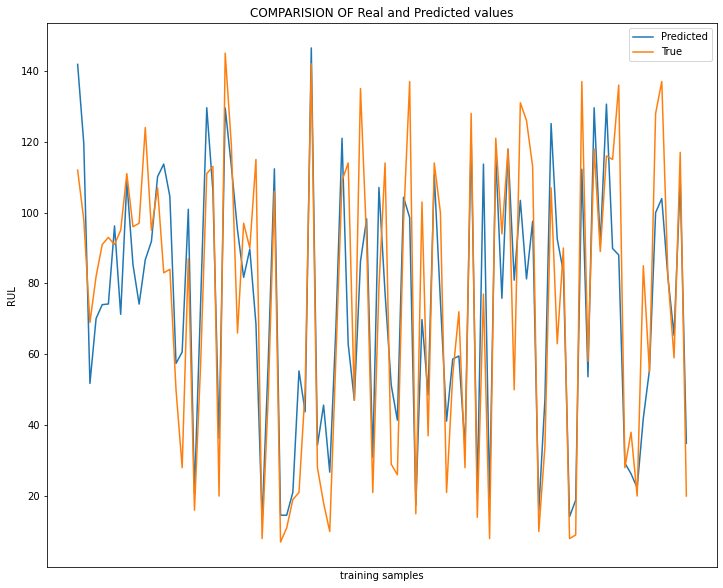

In [53]:
plot_result(y_true,y_5_pred_xgb)

In [54]:
def Bar_Plots(RF_score_lst, XGB_score_lst, LSTM_score_lst=0):
    hue = ["mae","rmse", "r2"]
    
    if LSTM_score_lst != 0: 
        df = pd.DataFrame(zip(hue*3, ["RFRegrssor"]*3+["LSTM"]*3+["XGBRegressor"]*3, RF_score_lst+LSTM_score_lst+XGB_score_lst), columns=["Parameters", "Models", "Scores"])
    else:
        df = pd.DataFrame(zip(hue*3, ["RFRegrssor"]*3+["XGBRegressor"]*3, RF_score_lst+XGB_score_lst), columns=["Parameters", "Models", "Scores"])

    print(df.head(10))
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Models", y="Scores", hue="Parameters", data=df)
    plt.show()

  Parameters        Models  Scores
0        mae    RFRegrssor   19.25
1       rmse    RFRegrssor   24.45
2         r2    RFRegrssor   65.00
3        mae          LSTM   15.96
4       rmse          LSTM    0.00
5         r2          LSTM   67.00
6        mae  XGBRegressor   20.36
7       rmse  XGBRegressor   24.35
8         r2  XGBRegressor   66.00


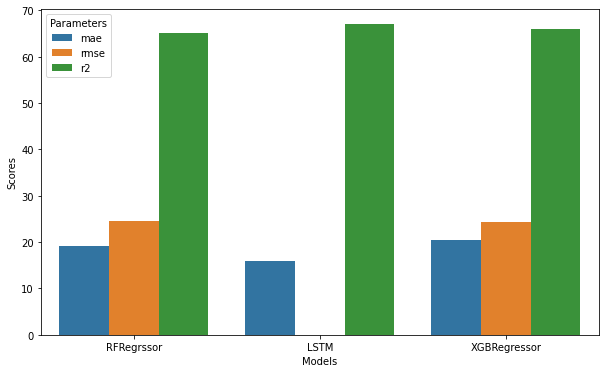

In [55]:
Bar_Plots(RF_individual_scorelst, XGB_individual_scorelst, LSTM_individual_scorelst)

  Parameters        Models  Scores
0        mae    RFRegrssor   16.49
1       rmse    RFRegrssor   21.34
2         r2    RFRegrssor   74.00
3        mae  XGBRegressor   19.16
4       rmse  XGBRegressor   22.96
5         r2  XGBRegressor   69.00


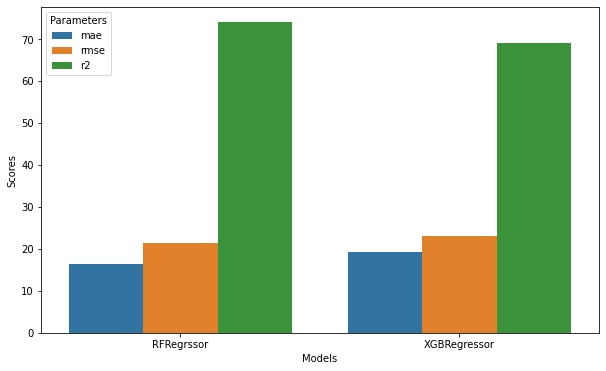

In [56]:
Bar_Plots(RF_SingleTrain_scorelst, XGB_SingleTrain_scorelst)

  Parameters        Models  Scores
0        mae    RFRegrssor   17.78
1       rmse    RFRegrssor   22.17
2         r2    RFRegrssor   72.00
3        mae  XGBRegressor   16.12
4       rmse  XGBRegressor   20.64
5         r2  XGBRegressor   75.00


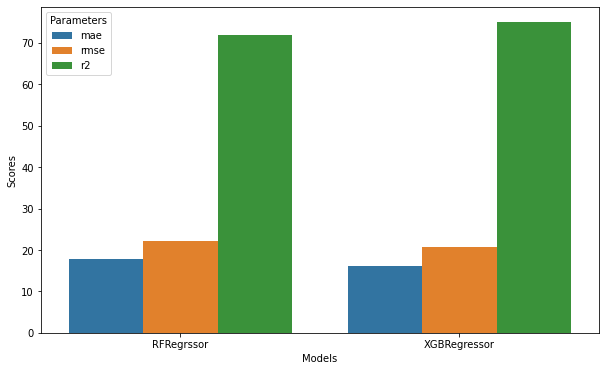

In [57]:
Bar_Plots(RF_5avg_scorelst, XGB_5avg_scorelst)

In [58]:
compare = pd.DataFrame(list(zip(y_true, y_pred, y_single_pred,y_multi_pred,y_multi_pred_10,y_xgb_pred,y_single_xgb_pred)), 
               columns =['True','Forest_Predicted','Forest_Single_predicted','multi_5','multi_10'
                         ,'XGBoost','XGBoost_single']) 
compare['unit_number'] = compare.index + 1

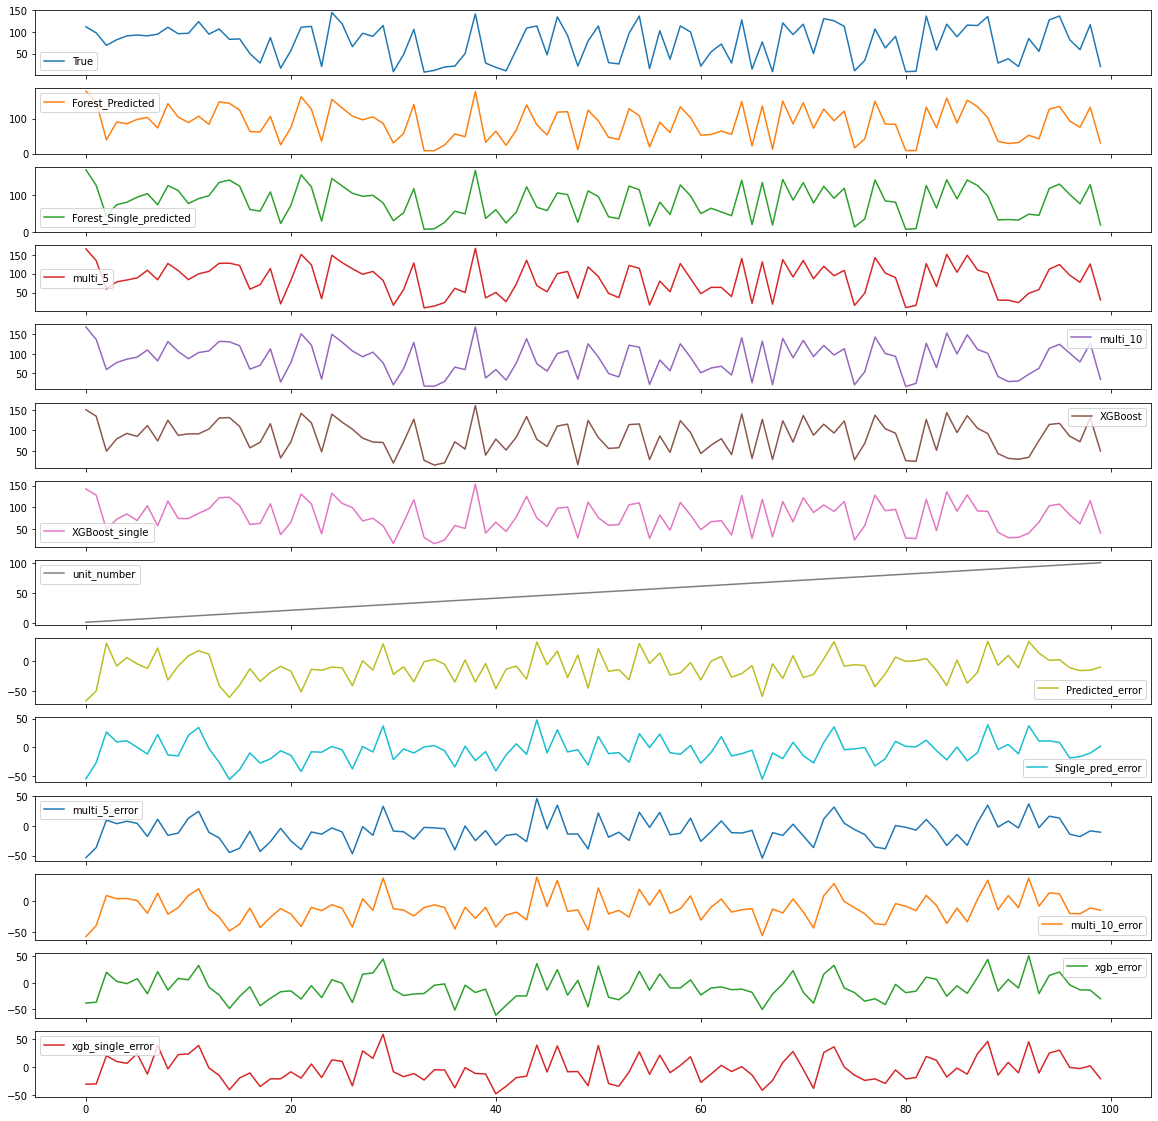

In [59]:
compare['Predicted_error'] = compare['True'] - compare['Forest_Predicted']
compare['Single_pred_error'] = compare['True'] - compare['Forest_Single_predicted']
compare['multi_5_error'] = compare['True'] - compare['multi_5']
compare['multi_10_error'] = compare['True'] - compare['multi_10']
compare['xgb_error'] = compare['True'] - compare['XGBoost']
compare['xgb_single_error'] = compare['True'] - compare['XGBoost_single']
ax1 = compare.plot(subplots=True, sharex=True, figsize=(20,20))

In [60]:
TTF = 10
train_df['label'] = np.where(train_df['RUL'] <= TTF, 1, 0 )

Text(0.5, 1.0, 'Scatter patter Nc or T50')

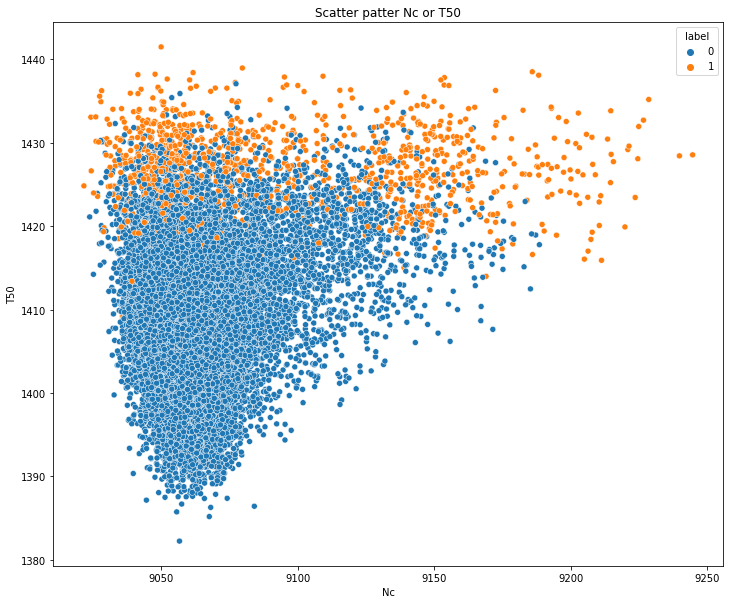

In [61]:
sns.scatterplot(x="Nc", y="T50", hue="label", data=train_df)
plt.title('Scatter patter Nc or T50')

In [62]:
X_class = train_df.iloc[:,:14].to_numpy() 
Y_class = train_df.iloc[:,15:].to_numpy()
Y_class = np.ravel(Y_class)
X_class

array([[1.00000e+00, 6.41820e+02, 1.58970e+03, ..., 3.92000e+02,
        3.90600e+01, 2.34190e+01],
       [2.00000e+00, 6.42150e+02, 1.59182e+03, ..., 3.92000e+02,
        3.90000e+01, 2.34236e+01],
       [3.00000e+00, 6.42350e+02, 1.58799e+03, ..., 3.90000e+02,
        3.89500e+01, 2.33442e+01],
       ...,
       [1.98000e+02, 6.43420e+02, 1.60246e+03, ..., 3.98000e+02,
        3.84400e+01, 2.29333e+01],
       [1.99000e+02, 6.43230e+02, 1.60526e+03, ..., 3.95000e+02,
        3.82900e+01, 2.30640e+01],
       [2.00000e+02, 6.43850e+02, 1.60038e+03, ..., 3.96000e+02,
        3.83700e+01, 2.30522e+01]])

In [63]:
Y_class

array([0, 0, 0, ..., 1, 1, 1])

In [64]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_class,Y_class,test_size = 0.2,random_state = 3)

In [65]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [66]:
forest = RandomForestClassifier(n_estimators=70 ,max_depth = 8, random_state=193)
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, n_estimators=70, random_state=193)

In [67]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:11:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [69]:
def classificator_score(y_,y_p):
    print(f' accuracy score {round(accuracy_score(y_, y_p),2)}')
    print(f' precision score {round(precision_score(y_, y_p),2)}')
    print(f' recall score {round(recall_score(y_, y_p),2)}')
    print(f' F1 score {round(f1_score(y_, y_p),2)}')
    return

In [70]:
classificator_score(y_test,forest.predict(X_test))

 accuracy score 0.98
 precision score 0.8
 recall score 0.8
 F1 score 0.8


In [71]:
y_xgb_pred = model_xgb.predict(X_001_test)
classificator_score(y_test,model_xgb.predict(X_test))

 accuracy score 0.98
 precision score 0.82
 recall score 0.81
 F1 score 0.82


In [72]:
test.head()

,time_in_cycles,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32
0,31,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8.4024,393,38.81,23.3552
1,49,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8.4505,391,38.81,23.2618
2,126,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8.4119,395,38.93,23.2740
3,106,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8.4634,395,38.58,23.2581
4,98,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8.4362,394,38.75,23.4117


In [73]:
X_001_test = test.to_numpy()

In [74]:
predicted = pd.DataFrame()
predicted ['forest'] =  forest.predict(X_001_test)
predicted['XGB'] = y_xgb_pred
predicted['RUL']=RUL[0]
predicted['true_label'] = np.where(y_true <= TTF, 1, 0 )
predicted['unit_number'] = predicted.index + 1

In [75]:
predicted.head()

,forest,XGB,RUL,true_label,unit_number
0,0,0,112,0,1
1,0,0,98,0,2
2,0,0,69,0,3
3,0,0,82,0,4
4,0,0,91,0,5


In [76]:
predicted[predicted['true_label'] == 1]

,forest,XGB,RUL,true_label,unit_number
30,0,1,8,1,31
33,1,0,7,1,34
41,0,0,10,1,42
67,0,0,8,1,68
75,0,0,10,1,76
80,1,0,8,1,81
81,1,0,9,1,82


In [77]:
predicted[predicted['true_label'] != predicted['forest']]

,forest,XGB,RUL,true_label,unit_number
30,0,1,8,1,31
34,1,0,11,0,35
41,0,0,10,1,42
67,0,0,8,1,68
75,0,0,10,1,76


In [78]:
predicted[predicted['true_label'] != predicted['XGB']]

,forest,XGB,RUL,true_label,unit_number
33,1,0,7,1,34
41,0,0,10,1,42
67,0,0,8,1,68
75,0,0,10,1,76
80,1,0,8,1,81
81,1,0,9,1,82


In [79]:
y_true_class = np.where(y_true <= TTF, 1, 0 )
y_pred_class = predicted['forest'].tolist()

In [80]:
def expected_profit(y_true,y_pred):
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(len(y_true)):
        if (y_true[i] != y_pred[i]) & (y_pred[i] == 1):
            FP += 1
        elif (y_true[i] != y_pred[i]) & (y_pred[i] == 0):
            FN += 1
        elif (y_true[i] == y_pred[i]) & (y_pred[i] == 0):
            TN += 1
        else:
            TP += 1
    print(f'TP ={TP}, TN = {TN}, FP = {FP}, FN = {FN}')
    print (f'expected profit {(300 * TP - 200 * FN - 100 * FP) * 1000}')
    return 

In [81]:
def confusion_matrix(actual, predicted):
    plt.figure(figsize=(5,5))
    sns.heatmap(sklearn.metrics.confusion_matrix(actual,predicted),annot=True,fmt='.5g')
    plt.ylabel('actual class')
    plt.xlabel('predicted class')
    plt.show()

TP =3, TN = 92, FP = 1, FN = 4
expected profit 0


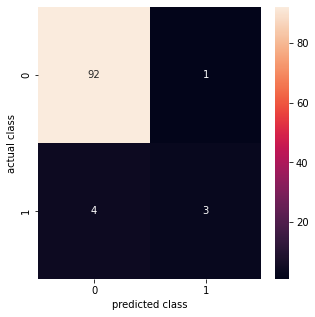

In [82]:
expected_profit(y_true_class,y_pred_class)
confusion_matrix(y_true_class, y_pred_class)

TP =1, TN = 93, FP = 0, FN = 6
expected profit -900000


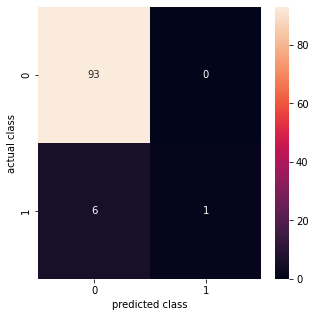

In [83]:
expected_profit(y_true_class,y_xgb_pred)
confusion_matrix(y_true_class, y_xgb_pred)

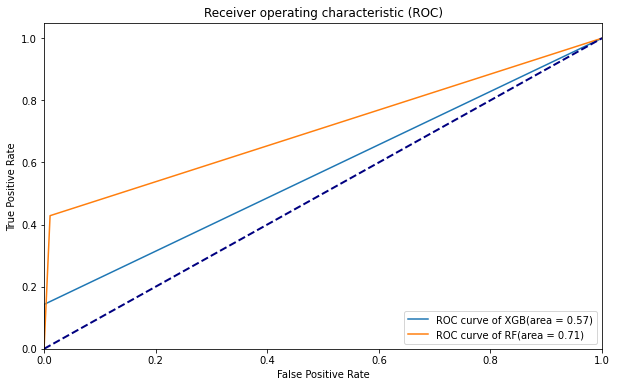

In [84]:
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_true_class,  y_xgb_pred)                      
fpr_RF, tpr_RF, _ = metrics.roc_curve(y_true_class,  y_pred_class)
auc_xgb = metrics.auc(fpr_xgb,  tpr_xgb)
auc_RF = metrics.auc(fpr_RF,  tpr_RF)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb,tpr_xgb, label='ROC curve of XGB(area = %0.2f)' % auc_xgb)
plt.plot(fpr_RF,tpr_RF, label='ROC curve of RF(area = %0.2f)' % auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()